In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [2]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(pheatmap)
library(gplots)
library(svglite)
library(ggrastr)
library(matrixStats)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [3]:
library(future)
plan("multiprocess", workers = availableCores())
options(future.globals.maxSize= +Inf)

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


## Save Directories for Figs + Tables

In [3]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Custom Functions:

In [16]:
make_volcano_plot <- function(data, labeled_pts, labeled_genes=c(), p_val_cutoff=0.01) {
    data <- data %>% 
    mutate(
        Expression = case_when(avg_log2FC >= 1 & p_val_adj <= p_val_cutoff ~ "Up-regulated",
                           avg_log2FC <= -1 & p_val_adj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )
    
    data <- data %>% filter(gene!='hSOD1')


    top <- labeled_pts
   
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(gene %in% labeled_genes)
    )
    
    
#     top_genes$Genes <- rownames(top_genes)
    
    x_scale <- max(abs(data$avg_log2FC))
    
    p1 <- ggplot(data, aes(avg_log2FC, -log(p_val_adj,10))) + # -log10 conversion 
        geom_point(aes(color = Expression), size = 4/5) +
        geom_label_repel(data = top_genes, mapping = aes(avg_log2FC, -log(p_val_adj,10), label = gene),
                        size = 4, max.overlaps=18)+
        xlim(-x_scale,x_scale)+
        xlab(expression("log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"(p adj)")) + 
        scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        theme_classic() +
        theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15))       
p1  
}

## Data Loading and Pre-Processing

In [3]:
data_dir <- '/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_aggr/outs/count/filtered_feature_bc_matrix'
gautier <- Read10X(data.dir = data_dir) %>% CreateSeuratObject()

In [4]:
# Remove mitochondrial reads
counts <- GetAssayData(gautier, assay = "RNA")
mito_genes <- grep( "^MT-", rownames(gautier), value = T)
counts <- counts[-(which(rownames(counts) %in% mito_genes)),]
gautier <- subset(gautier, features = rownames(counts))

In [5]:
# Normalize, identify variable features, and scale the data
gautier <- NormalizeData(gautier, normalization.method = "LogNormalize", scale.factor = 10000)
gautier <- FindVariableFeatures(gautier, selection.method = "vst", nfeatures = 33000)
all.genes <- rownames(gautier)
gautier <- ScaleData(gautier, features = all.genes)

Centering and scaling data matrix



In [6]:
# PCA
gautier <- RunPCA(gautier, features = VariableFeatures(object = gautier))

PC_ 1 
Positive:  FGF14, ATP8A2, MEG8, FGF12, MYT1L, AGBL4, MAP2, FAM155A, SLC4A10, KSR2 
	   MEG3, SCN2A, SCN1A, PAK3, STXBP5L, CNTN1, UNC80, SORBS2, SNRPN, PTPRN2 
	   KAZN, SYT1, GABRB3, DLGAP2, LRFN5, DCLK1, ROBO2, LINGO2, DLGAP1, CACNA1C 
Negative:  QKI, MBP, ST18, PLP1, TMEM144, TF, RNF220, C10orf90, SPP1, PTGDS 
	   MOG, PIP4K2A, AL033523.1, SLC5A11, ANLN, BCAS1, ENPP2, TMEM63A, GAB1, AL359091.1 
	   CLDN11, ABCA8, UGT8, SLC44A1, CTNNA3, SELENOP, SYNJ2, DOCK5, MOBP, NCKAP5 
PC_ 2 
Positive:  SRGN, CD74, INPP5D, PTPRC, RGS1, TNFRSF1B, FYB1, ARHGAP15, HLA-DRA, ADAM28 
	   HLA-DRB1, HIF1A, LNCAROD, MEF2C, SLCO2B1, SAT1, CIITA, CPVL, CEBPD, APBB1IP 
	   CD86, TBXAS1, RIN3, C3, LYN, FLI1, TLR2, CSF2RA, ABCC4, CELF2 
Negative:  DNM3, FRMD5, PCDH9, IL1RAPL1, DLC1, NKAIN2, OTUD7A, UNC5C, SLC24A2, EDIL3 
	   PRUNE2, APBB2, PEX5L, NTM, CNTNAP4, KLHL32, PLEKHH1, SLAIN1, SLC44A1, PKP4 
	   TMTC2, CTNNA3, RAPGEF5, COLGALT2, TF, DST, LRRTM3, PCSK6, NPAS3, ST18 
PC_ 3 
Positive:  LRMDA, ARHGAP

In [7]:
# Cluster
gautier <- FindNeighbors(gautier, dims = 1:20)
gautier <- FindClusters(gautier, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21697
Number of edges: 693503

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9416
Number of communities: 25
Elapsed time: 2 seconds


In [8]:
# UMAP
gautier <- RunUMAP(gautier, dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
13:57:55 UMAP embedding parameters a = 0.9922 b = 1.112

13:57:55 Read 21697 rows and found 20 numeric columns

13:57:55 Using Annoy for neighbor search, n_neighbors = 30

13:57:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:57:57 Writing NN index file to temp file /tmp/RtmpkjlyoR/file47e62787d45b

13:57:57 Searching Annoy index using 1 thread, search_k = 3000

13:58:05 Annoy recall = 100%

13:58:06 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

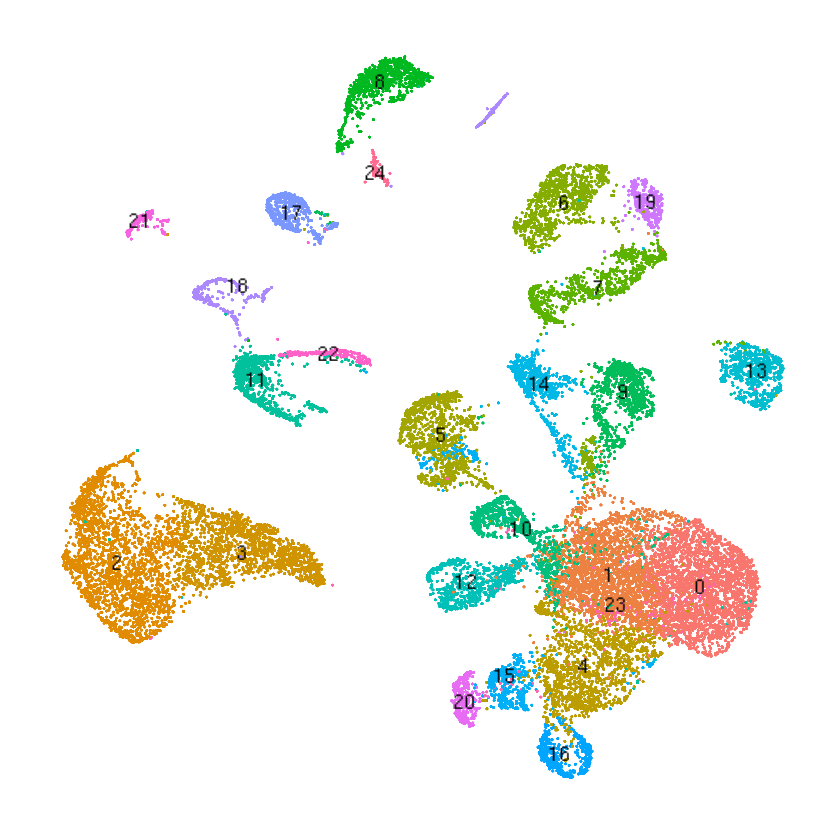

In [31]:
gautier_UMAP <- DimPlot(gautier, reduction = "umap", label = TRUE) + NoAxes() + NoLegend()
gautier_UMAP <- rasterize(gautier_UMAP, layers='Point', dpi=500)
gautier_UMAP

In [32]:
ggsave(gautier_UMAP, filename = paste(fig_dir, 'gautier_UMAP.svg', sep='/'), device='svg', width = 3, height = 3, units = "in")

## Cell class heatmap

### Cell type marker genes

In [33]:
neuron_marker <- c('RBFOX3')
astro_marker <- c('AQP4')
microglia_marker <- c('CSF1R')
endo_marker <- c('FLT1')
oligo_marker <- c('MOBP')
cholin_marker <- c('SLC5A7')
opc_fibro_marker <- c('PDGFRA')
debris_marker <- c('NEFH')

all.markers <- c(oligo_marker, astro_marker, microglia_marker, opc_fibro_marker, endo_marker, 
                 neuron_marker, cholin_marker, debris_marker)

In [34]:
Idents(gautier) <- gautier$seurat_clusters
heatmap.avgexp <- AverageExpression(gautier, features=all.markers)

### Average UMI count per cluster

In [35]:
avg_nCount_RNA <- gautier@meta.data %>% dplyr::group_by(seurat_clusters) %>% dplyr::summarise(dplyr::across(nCount_RNA, ~ mean(.))) %>% as.data.frame()

### Average proportion of intron-containing reads per cluster

In [36]:
S1_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_with_introns/S1_Cerv_131/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
S1_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_without_introns/S1_Cerv_131_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [ ]:
S2_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_with_introns/S2_Cerv_131/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
S2_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Cerv_131_without_introns/S2_Cerv_131_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [ ]:
S1_with_introns$barcode <- rownames(S1_with_introns@meta.data)
S1_without_introns$barcode <- rownames(S1_without_introns@meta.data)

In [ ]:
S2_with_introns$barcode <- rownames(S2_with_introns@meta.data)
S2_with_introns@meta.data <- S2_with_introns@meta.data %>% mutate(barcode = stringr::str_replace(barcode, "1", "2"))
S2_with_introns <- RenameCells(S2_with_introns, new.names = S2_with_introns$barcode) 

In [ ]:
S2_without_introns$barcode <- rownames(S2_without_introns@meta.data)
S2_without_introns@meta.data <- S2_without_introns@meta.data %>% mutate(barcode = stringr::str_replace(barcode, "1", "2"))
S2_without_introns <- RenameCells(S2_without_introns, new.names = S2_without_introns$barcode) 

In [ ]:
with_introns <- dplyr::bind_rows(S1_with_introns@meta.data, S2_with_introns@meta.data)
without_introns <- dplyr::bind_rows(S1_without_introns@meta.data, S2_without_introns@meta.data)

In [ ]:
prop_intronic <- inner_join(with_introns, without_introns, by = "barcode")

In [ ]:
prop_intronic$prop_intronic <- (prop_intronic$nCount_RNA.x - prop_intronic$nCount_RNA.y)/prop_intronic$nCount_RNA.x

In [ ]:
rownames(prop_intronic) <- prop_intronic$barcode
prop_intronic <- prop_intronic %>% dplyr::select(prop_intronic) %>% dplyr::filter(rownames(.) %in% rownames(gautier@meta.data))

In [ ]:
gautier_prop_intronic <- AddMetaData(gautier, prop_intronic)

In [38]:
avg_prop_intronic <- gautier_prop_intronic@meta.data %>% dplyr::group_by(seurat_clusters) %>% dplyr::summarise(dplyr::across(prop_intronic, ~ mean(.))) %>% as.data.frame()

### Combine data and make heatmap

In [39]:
heatmap.combo <- as.data.frame(t(heatmap.avgexp$RNA))
heatmap.combo$seurat_clusters <- rownames(heatmap.combo)
heatmap.combo <- dplyr::full_join(heatmap.combo, avg_nCount_RNA, by = "seurat_clusters") %>% dplyr::full_join(., avg_prop_intronic, by = "seurat_clusters") 
row.names(heatmap.combo) <- heatmap.combo$seurat_clusters
heatmap.combo <- dplyr::select(heatmap.combo, -seurat_clusters) %>% t(.)
heatmap.combo <- (heatmap.combo - rowMins(heatmap.combo))/(rowMaxs(heatmap.combo) - rowMins(heatmap.combo))

In [40]:
order <- c('2','3','17','8','21','18','6','19','14','16','0','23','1','20','12','15','4','9','10','13','5','7','24','11','22')
heatmap.combo <- heatmap.combo[,order]

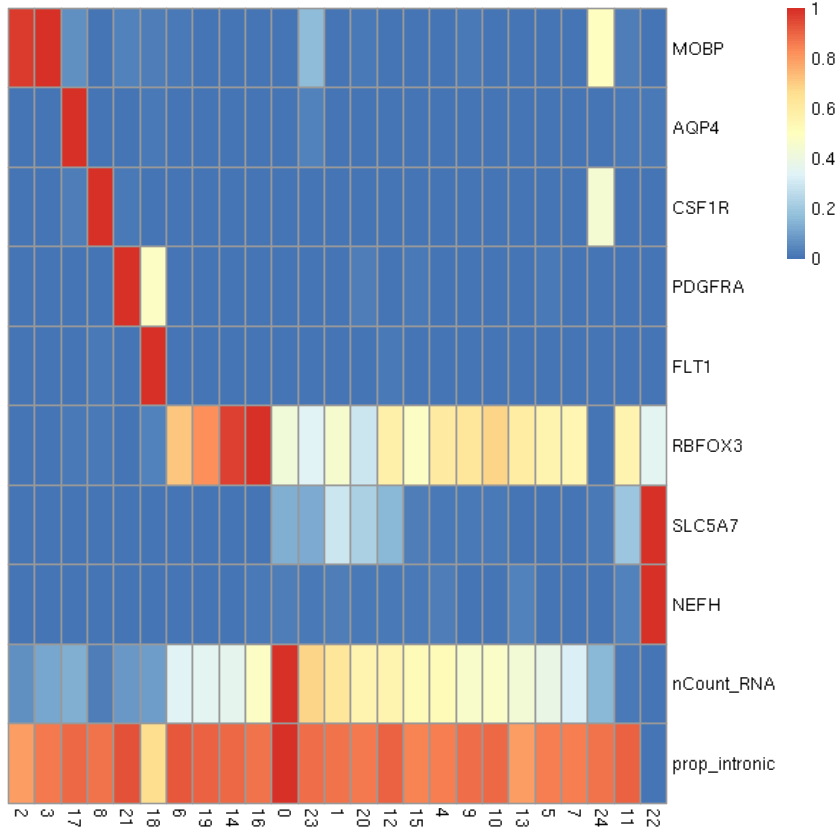

In [41]:
pheatmap(heatmap.combo, cluster_rows = FALSE, cluster_cols = FALSE)

In [44]:
pheatmap(heatmap.combo, cluster_rows = FALSE, cluster_cols = FALSE, filename = paste(fig_dir, 'cell_class_heatmap.pdf', sep='/'), width = 3.4, height = 1.6, fontsize = 7)

In [206]:
gautier_prop_intronic$top_level_annotation <- "Neurons"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("2", "3")] <- "Oligodenrocytes"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("17")] <- "Astrocytes"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("8")] <- "Microglia/Macrophages"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("21")] <- "OPCs"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("18")] <- "Endothelial Cells/Fibroblasts"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("24")] <- "Non-Neuronal Doublets"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("11")] <- "Low Quality Nuclei"
gautier_prop_intronic$top_level_annotation[gautier_prop_intronic$seurat_clusters %in% c("22")] <- "Non-Nuclear Debris"

### Labeled UMAP

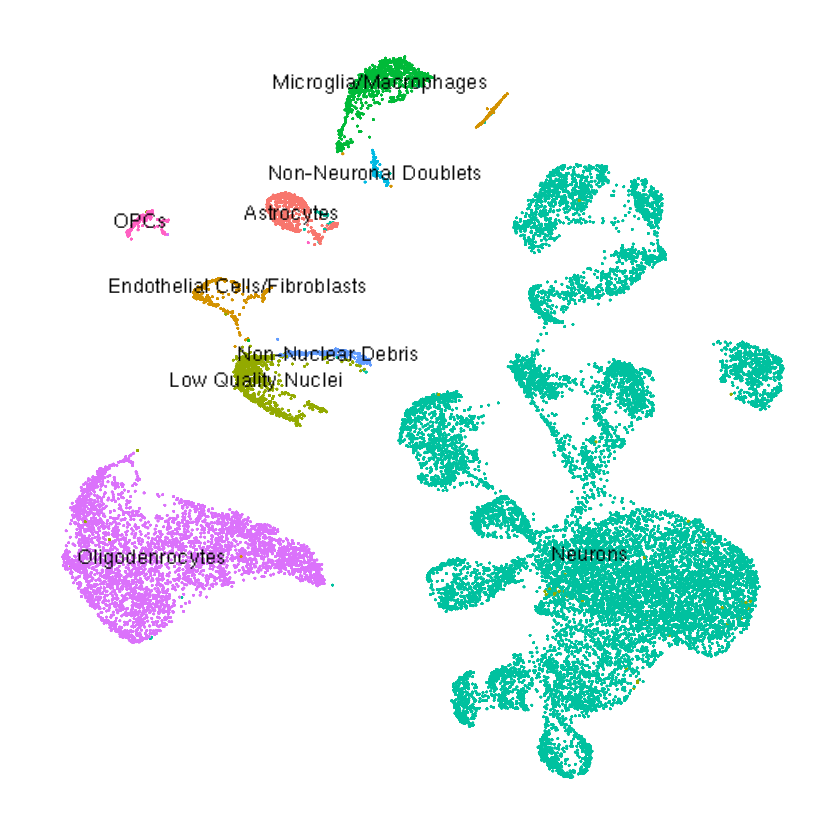

In [27]:
gautier_UMAP_labeled <- DimPlot(object = gautier_prop_intronic, reduction = 'umap', group.by = "top_level_annotation", label = TRUE) + NoAxes() + NoLegend() + theme(plot.title = element_blank())
gautier_UMAP_labeled <- rasterize(gautier_UMAP_labeled, layers='Point', dpi=500)
gautier_UMAP_labeled

In [28]:
ggsave(gautier_UMAP_labeled, filename = paste(fig_dir, 'gautier_UMAP_labeled.svg', sep='/'), device='svg', width = 3, height = 3, units = "in")

## Cluster 22 volcano plot

In [294]:
# Get number of cells per top_level_annotation 
table(gautier@meta.data$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2486 2387 2247 1509 1423 1113 1061  875  875  874  865  834  733  632  624  531 
  16   17   18   19   20   21   22   23   24 
 488  482  381  313  285  218  214  163   84 

In [17]:
Idents(gautier) <- gautier$seurat_clusters
debris.markers <- FindMarkers(gautier, ident.1 = 22, max.cells.per.ident = 214, logfc.threshold=0, min.pct=0) 
debris.markers$gene <- rownames(debris.markers)
rownames(debris.markers) <- NULL

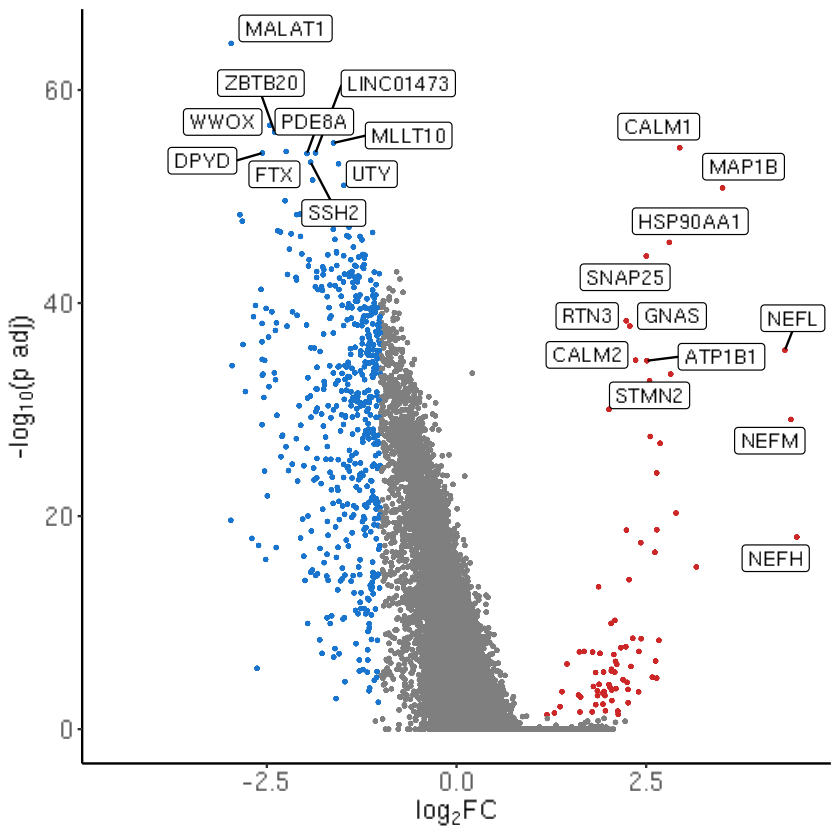

In [18]:
debris_volcano_markers <- make_volcano_plot(as_tibble(debris.markers), 10, labeled_genes = c("NEFH", "NEFM"), p_val_cutoff = 0.05)
debris_volcano_markers <- rasterize(debris_volcano_markers, layers="Point", dpi=500) + NoLegend()
debris_volcano_markers

In [19]:
ggsave(debris_volcano_markers, filename = paste(fig_dir, 'debris_volcano_markers.svg', sep='/'), device='svg', width = 6.4, height = 4.848, units = "in")

## Subcluster neurons

In [215]:
Idents(gautier_prop_intronic) <- gautier_prop_intronic$top_level_annotation
gautier_neurons <- subset(gautier_prop_intronic, idents = "Neurons")

In [216]:
gautier_neurons <- FindVariableFeatures(gautier_neurons, selection.method = "vst", nfeatures = 33000)
all.genes <- rownames(gautier_neurons)
gautier_neurons <- ScaleData(gautier_neurons, features = all.genes)

Centering and scaling data matrix



In [217]:
# PCA
gautier_neurons <- RunPCA(gautier_neurons, features = VariableFeatures(object = gautier_neurons))

PC_ 1 
Positive:  EBF3, CELF2, SCG2, CACNA1E, EBF1, ITM2C, NYAP2, ANKFN1, CALB1, PLXNA2 
	   SYT10, SPOCK1, CAMK2A, CAMK2N1, MARCKS, CPNE4, PRLR, FNBP1L, SYNPR, ENC1 
	   LY6H, NRP1, CPNE8, TUBA1A, SST, DOCK8, CACNA1G, PDE11A, MIR137HG, EBF2 
Negative:  KIAA1217, FOCAD, AC005906.2, ROBO1, ESRRG, ELAVL4, ADAM23, MIR34AHG, NOVA1, UBA6-AS1 
	   GRIA4, ATP8A2, SCN1A, ATRNL1, STXBP5-AS1, SYT2, DGKB, DYSF, LINC00632, PDE10A 
	   DST, OSBPL6, MAST4, ADAM22, GAS2, BEND6, ELAVL2, TNRC6A, GPAT3, AL589740.1 
PC_ 2 
Positive:  GAPDH, HSP90AA1, ATP1B1, PEBP1, UBB, CALM1, SOD1, NDUFA4, TUBA1B, SRP14 
	   VAMP2, BEX1, DYNLL1, RPL7A, YWHAB, STMN2, TUBB2A, UBC, COX4I1, PRDX2 
	   CKB, EID1, TUBA4A, EIF1, HINT1, RPS15, GPX4, LAMP5, COX6A1, ATP5MC3 
Negative:  DSCAM, SEMA3C, GRID1, MAML3, LHFPL3, CACNA2D1, GREB1L, ROBO2, MTUS2, FRMPD4 
	   MAML2, DPYD, KLHL1, DOCK8, NAV3, BCL2, CSMD3, CPNE8, PDE11A, SLC35F4 
	   ARHGEF28, AC018742.1, MIR137HG, PDE4B, AC092691.1, PALLD, PRKG2, SPOCK1, SH3RF3, AP000829.1 


In [218]:
# Cluster
gautier_neurons <- FindNeighbors(gautier_neurons, dims = 1:50)
gautier_neurons <- FindClusters(gautier_neurons, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14853
Number of edges: 488552

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9422
Number of communities: 29
Elapsed time: 1 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [219]:
# UMAP
gautier_neurons <- RunUMAP(gautier_neurons, dims = 1:50)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:59:21 UMAP embedding parameters a = 0.9922 b = 1.112

20:59:21 Read 14853 rows and found 50 numeric columns

20:59:21 Using Annoy for neighbor search, n_neighbors = 30

20:59:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:59:23 Writing NN index file to temp file /tmp/Rtmpce4etU/file416740629ae3

20:59:23 Searching Annoy index using 12 threads, search_k = 3000

20:59:24 Annoy recall = 100%

20:59:26 Commencing smooth kNN distance calibration using 12 threads
 with target n_neighb

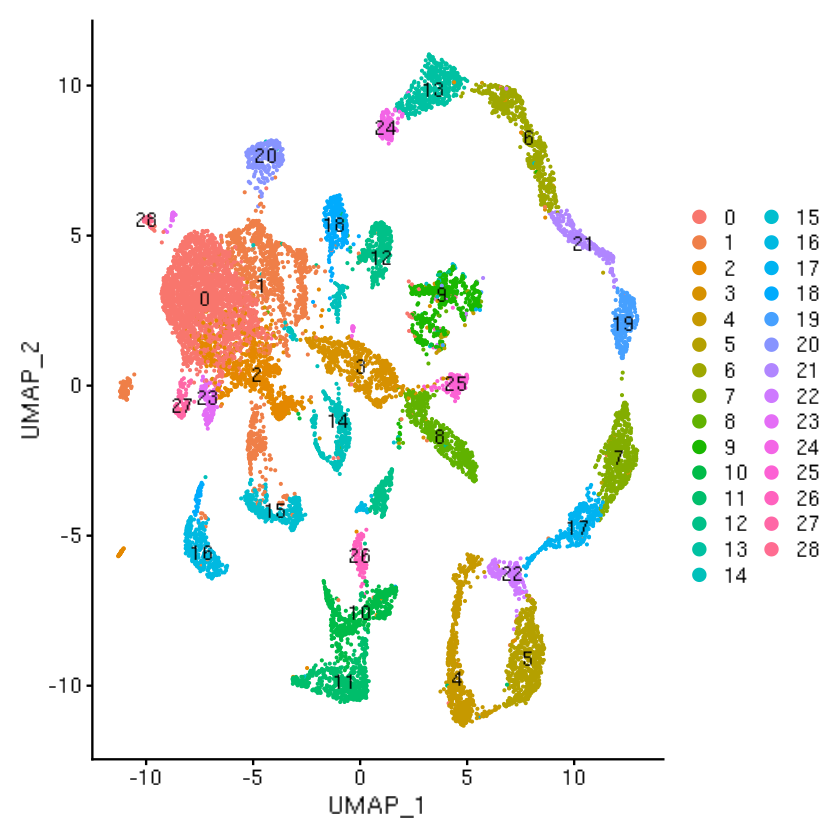

In [220]:
DimPlot(gautier_neurons, reduction = "umap", label = TRUE)

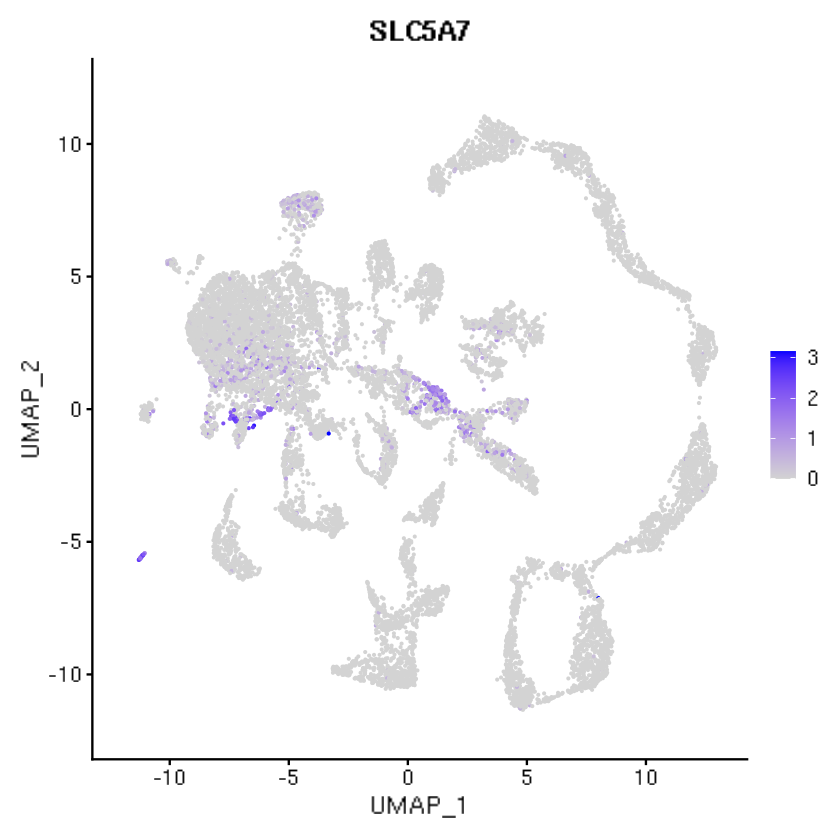

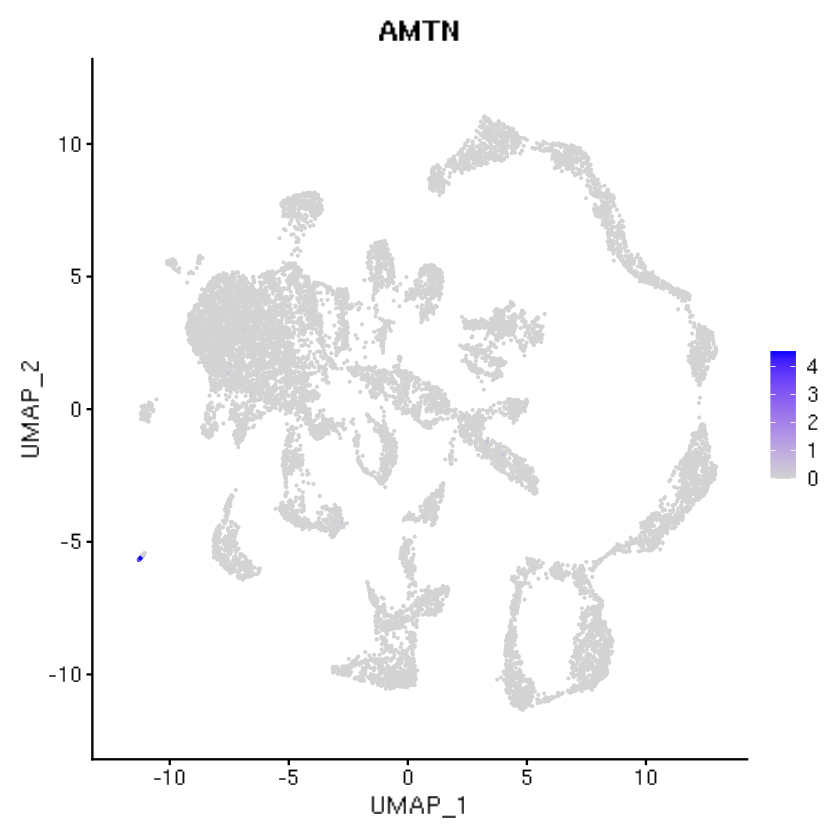

In [148]:
# Marker genes
FeaturePlot(gautier_neurons, features = c("SLC5A7"))
FeaturePlot(gautier_neurons, features = c("AMTN"))

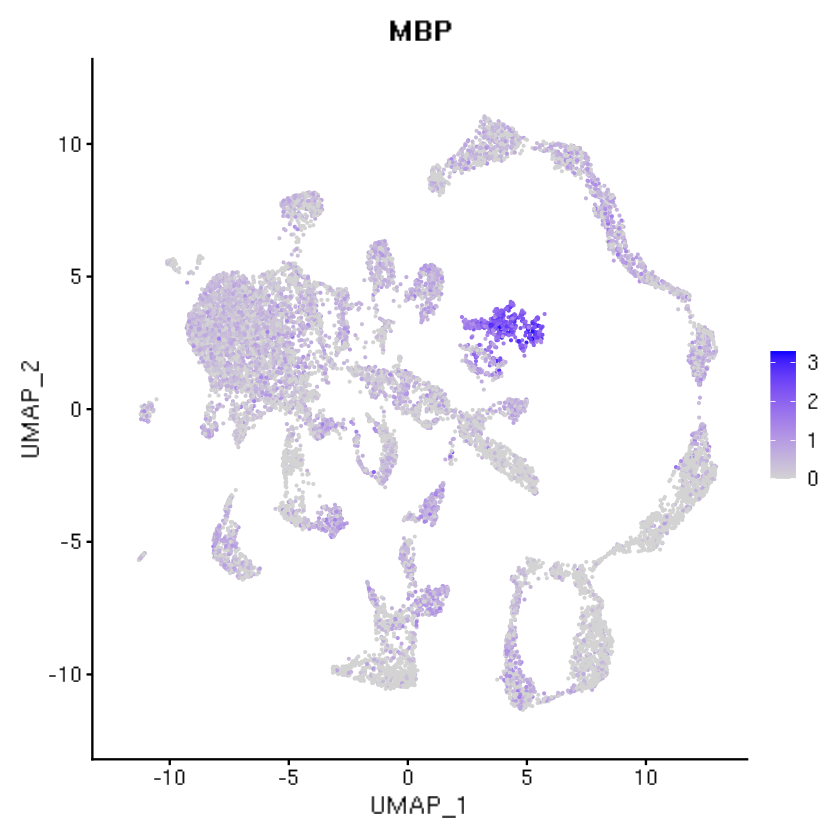

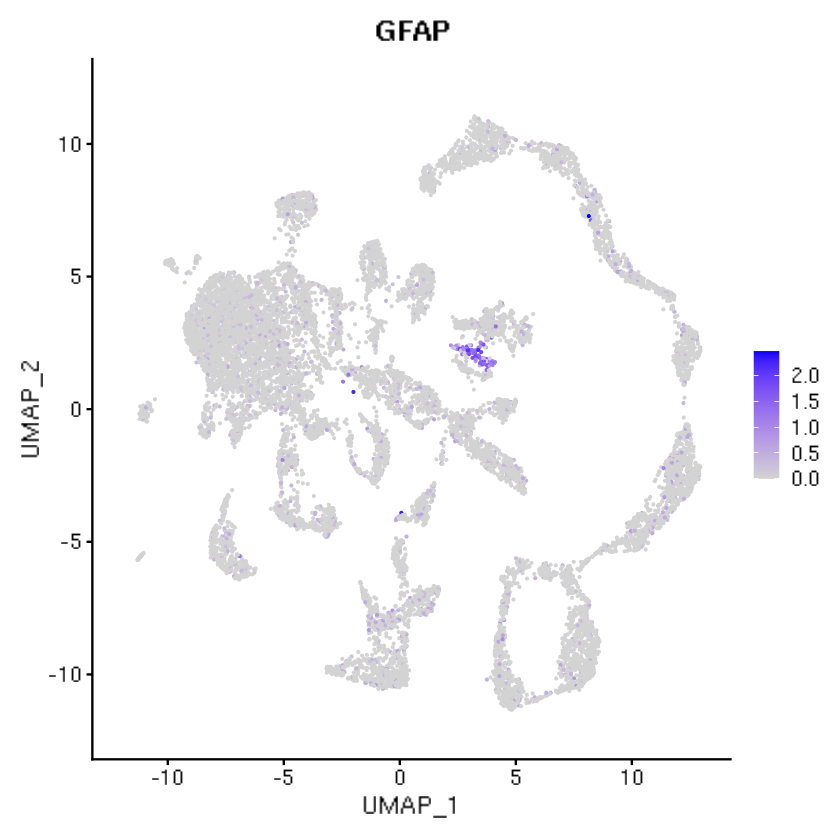

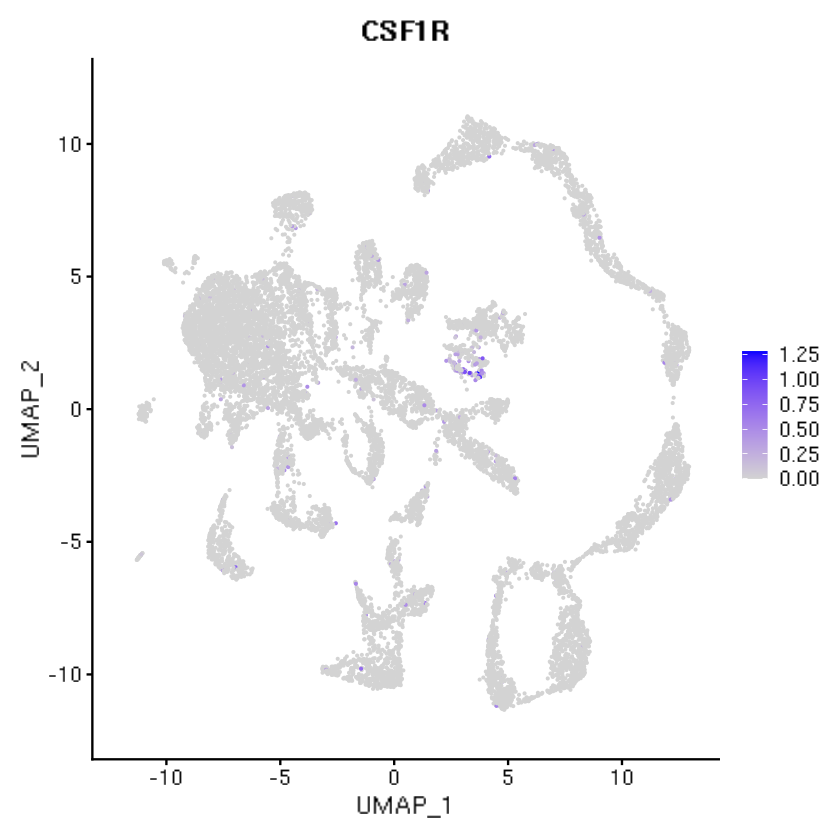

In [149]:
FeaturePlot(gautier_neurons, features = c("MBP"))
FeaturePlot(gautier_neurons, features = c("GFAP"))
FeaturePlot(gautier_neurons, features = c("CSF1R"))

In [221]:
# Remove cluster 9 and re-analyze
gautier_neurons <- subset(gautier_neurons, idents = c("9"), invert = TRUE)

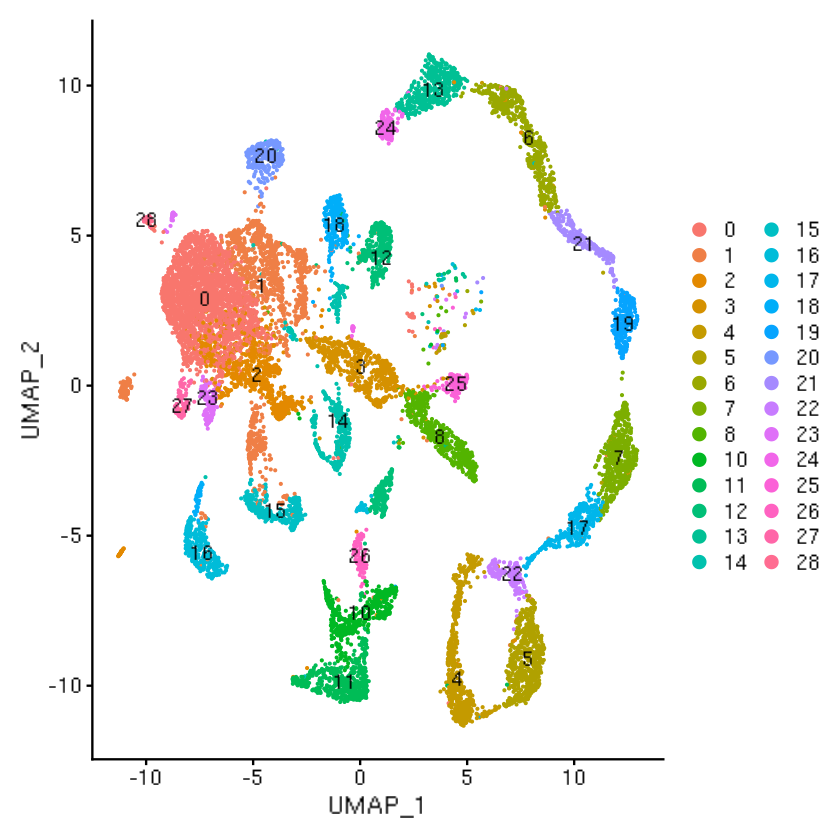

In [222]:
DimPlot(gautier_neurons, reduction = "umap", label = TRUE)

In [223]:
gautier_neurons <- FindVariableFeatures(gautier_neurons, selection.method = "vst", nfeatures = 33000)
all.genes <- rownames(gautier_neurons)
gautier_neurons <- ScaleData(gautier_neurons, features = all.genes)

Centering and scaling data matrix



In [224]:
# PCA
gautier_neurons <- RunPCA(gautier_neurons, features = VariableFeatures(object = gautier_neurons))

PC_ 1 
Positive:  KIAA1217, FOCAD, AC005906.2, ROBO1, ESRRG, ELAVL4, ADAM23, MIR34AHG, UBA6-AS1, NOVA1 
	   GRIA4, ATP8A2, SCN1A, ATRNL1, STXBP5-AS1, SYT2, DGKB, DYSF, LINC00632, DST 
	   PDE10A, OSBPL6, MAST4, ADAM22, NEAT1, GAS2, BEND6, TNRC6A, GPAT3, ELAVL2 
Negative:  EBF3, CELF2, SCG2, CACNA1E, EBF1, ITM2C, NYAP2, ANKFN1, CALB1, PLXNA2 
	   SYT10, SPOCK1, CAMK2A, CAMK2N1, MARCKS, CPNE4, PRLR, FNBP1L, SYNPR, LY6H 
	   NRP1, TUBA1A, ENC1, DOCK8, CPNE8, SST, CACNA1G, PDE11A, MIR137HG, EBF2 
PC_ 2 
Positive:  GAPDH, HSP90AA1, ATP1B1, PEBP1, UBB, CALM1, SOD1, NDUFA4, TUBA1B, SRP14 
	   VAMP2, BEX1, DYNLL1, RPL7A, YWHAB, STMN2, TUBB2A, PRDX2, UBC, COX4I1 
	   CKB, EID1, TUBA4A, EIF1, HINT1, RPS15, GPX4, LAMP5, GAD2, GAD1 
Negative:  DSCAM, SEMA3C, GRID1, MAML3, LHFPL3, CACNA2D1, GREB1L, ROBO2, MTUS2, FRMPD4 
	   MAML2, DPYD, KLHL1, DOCK8, BCL2, NAV3, CSMD3, CPNE8, PDE11A, SLC35F4 
	   ARHGEF28, AC018742.1, PDE4B, MIR137HG, AC092691.1, PALLD, PRKG2, SPOCK1, SH3RF3, LMX1B 
PC_ 3 
Positive

In [225]:
# Cluster
gautier_neurons <- FindNeighbors(gautier_neurons, dims = 1:50)
gautier_neurons <- FindClusters(gautier_neurons, resolution = 2.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14297
Number of edges: 473856

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8775
Number of communities: 54
Elapsed time: 1 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


In [226]:
# UMAP
gautier_neurons <- RunUMAP(gautier_neurons, dims = 1:50)

21:27:18 UMAP embedding parameters a = 0.9922 b = 1.112

21:27:18 Read 14297 rows and found 50 numeric columns

21:27:18 Using Annoy for neighbor search, n_neighbors = 30

21:27:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:27:20 Writing NN index file to temp file /tmp/Rtmpce4etU/file416739af1192

21:27:20 Searching Annoy index using 12 threads, search_k = 3000

21:27:20 Annoy recall = 100%

21:27:23 Commencing smooth kNN distance calibration using 12 threads
 with target n_neighbors = 30

21:27:26 Initializing from normalized Laplacian + noise (using irlba)

21:27:26 Commencing optimization for 200 epochs, with 580148 positive edges

21:27:43 Optimization finished



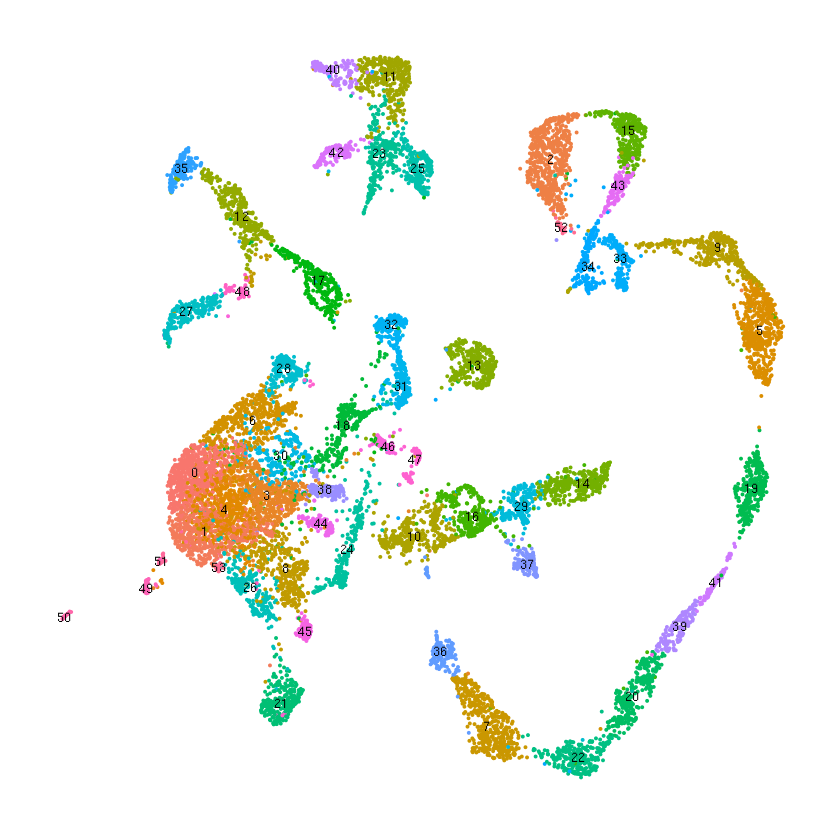

In [272]:
gautier_neurons_UMAP <- DimPlot(gautier_neurons, reduction = "umap", group.by = "seurat_clusters", pt.size = 0.05, label = TRUE, label.size = 2.5) + NoAxes() + NoLegend() + theme(plot.title = element_blank())
gautier_neurons_UMAP

In [35]:
ggsave(gautier_neurons_UMAP, filename = paste(fig_dir, 'gautier_neurons_UMAP.svg', sep='/'), device='svg', width = 3.6, height = 3.45, units = "in")

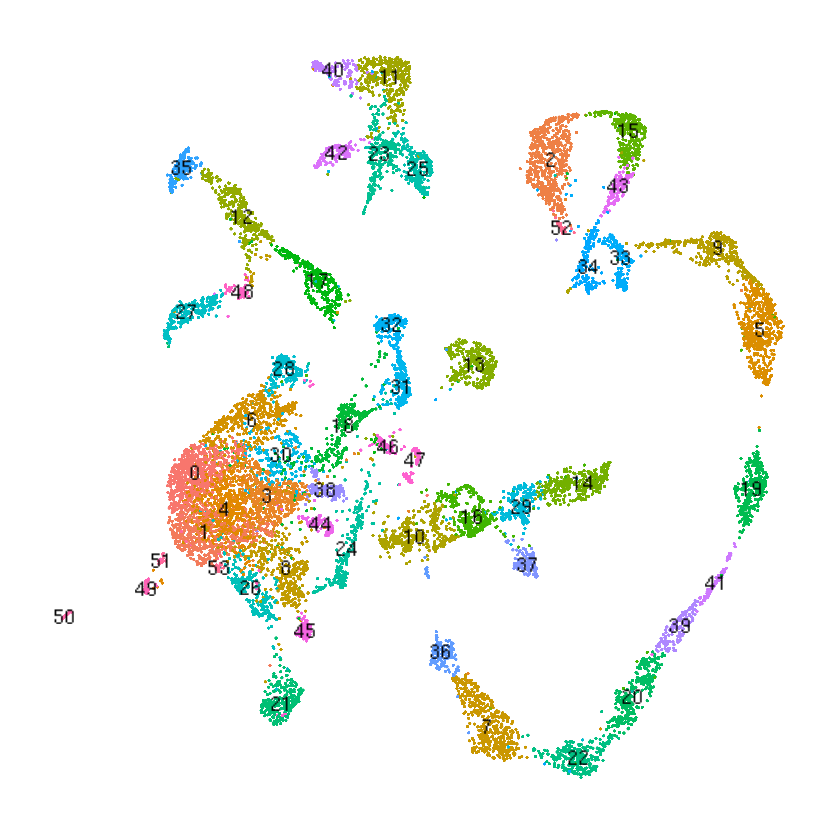

In [51]:
gautier_neurons_UMAP2 <- DimPlot(gautier_neurons, reduction = "umap", group.by = "seurat_clusters", label = TRUE) + NoAxes() + NoLegend() + theme(plot.title = element_blank())
gautier_neurons_UMAP2 <- rasterize(gautier_neurons_UMAP2, layers='Point', dpi=1000)
gautier_neurons_UMAP2

In [55]:
ggsave(gautier_neurons_UMAP2, filename = paste(fig_dir, 'gautier_neurons_UMAP2.svg', sep='/'), device='svg', width = 5.4, height = 4.8, units = "in")

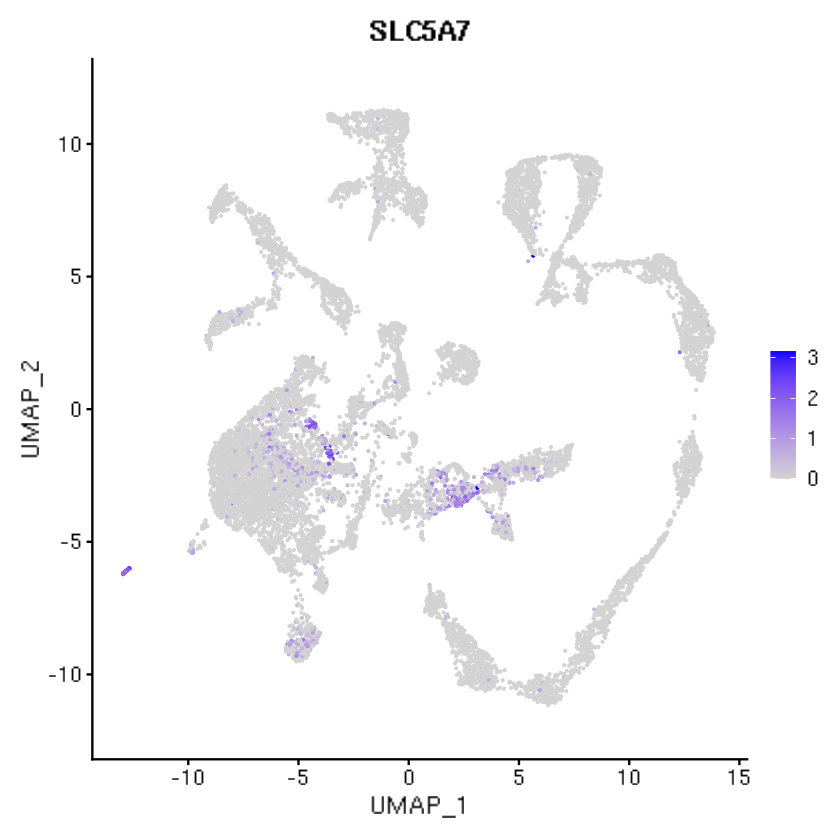

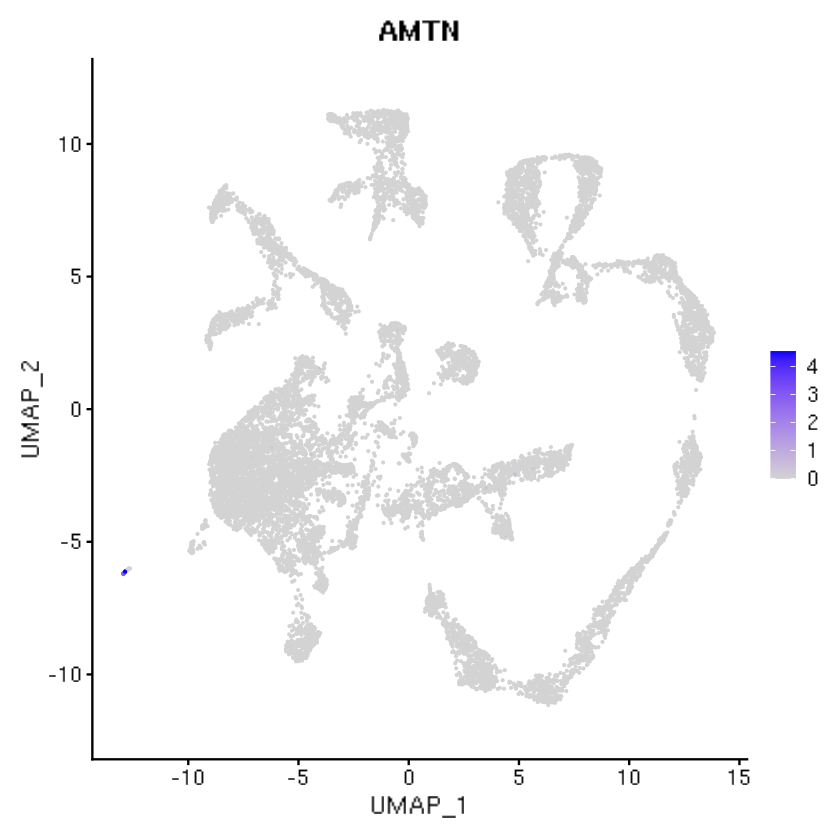

In [157]:
# Marker genes
FeaturePlot(gautier_neurons, features = c("SLC5A7"))
FeaturePlot(gautier_neurons, features = c("AMTN"))

In [228]:
# Get number of cells per cluster 
table(gautier_neurons@meta.data$seurat_clusters)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
637 600 586 561 549 539 520 462 415 402 393 386 358 352 352 346 342 334 332 310 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
309 294 284 281 267 267 240 238 220 218 211 201 198 188 186 174 161 157 157 152 
 40  41  42  43  44  45  46  47  48  49  50  51  52  53 
149 134 133 121 102  94  92  79  50  42  40  34  27  21 

In [93]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
neuron.markers <- FindAllMarkers(gautier_neurons, only.pos = TRUE, max.cells.per.ident = 21)
neuron.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34

Calculating cluster 35

Calculating cluster 36

Calculating cluster 37

Calculating cluster 38

Calculating cluster 39

Calculating cluster 40

Calculating cluster 41

Ca

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.570793e-03,1.475220,0.926,0.378,1.0000000000,0,AL589740.1
8.192509e-06,1.379041,0.969,0.295,0.2997475092,0,LRMDA
1.839135e-03,1.332931,0.980,0.591,1.0000000000,0,CDH12
5.121717e-04,1.265879,0.998,0.719,1.0000000000,0,KIAA1217
1.600778e-04,1.180930,0.994,0.786,1.0000000000,0,ESRRG
6.616427e-06,1.175629,0.958,0.470,0.2420818461,0,PARD3B
1.005541e-03,1.155542,0.575,0.173,1.0000000000,0,LINC02306
2.989082e-03,1.122587,0.989,0.844,1.0000000000,0,LRRTM4
1.781045e-04,1.106470,1.000,0.957,1.0000000000,0,DAB1


In [119]:
neuron.markers[neuron.markers$cluster == "24", ]

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
DMD4,1.511796e-05,0.9641455,1.000,0.865,0.5531359,24,DMD
NKAIN33,1.991311e-05,1.1412875,1.000,0.610,0.7285808,24,NKAIN3
MPPED23,1.991311e-05,0.3288944,0.951,0.764,0.7285808,24,MPPED2
SGCD4,2.093268e-05,2.1224643,0.951,0.650,0.7658848,24,SGCD
SLC27A66,2.516685e-05,0.4038616,0.873,0.557,0.9208046,24,SLC27A6
AC117461.14,2.713055e-05,1.2973647,0.978,0.559,0.9926524,24,AC117461.1
SLC35F12,3.266210e-05,0.5837940,1.000,0.830,1.0000000,24,SLC35F1
ROBO18,3.698637e-05,1.3816320,1.000,0.940,1.0000000,24,ROBO1
FAM184A,6.254227e-05,0.6622536,0.978,0.847,1.0000000,24,FAM184A


## Proceed without removing neuronal/neuronal doublets

## Violin plots

In [230]:
gautier_neurons$motor_neuron <- ifelse(gautier_neurons$seurat_clusters == "50", yes = "Motor Neurons", no = "Other Neurons")

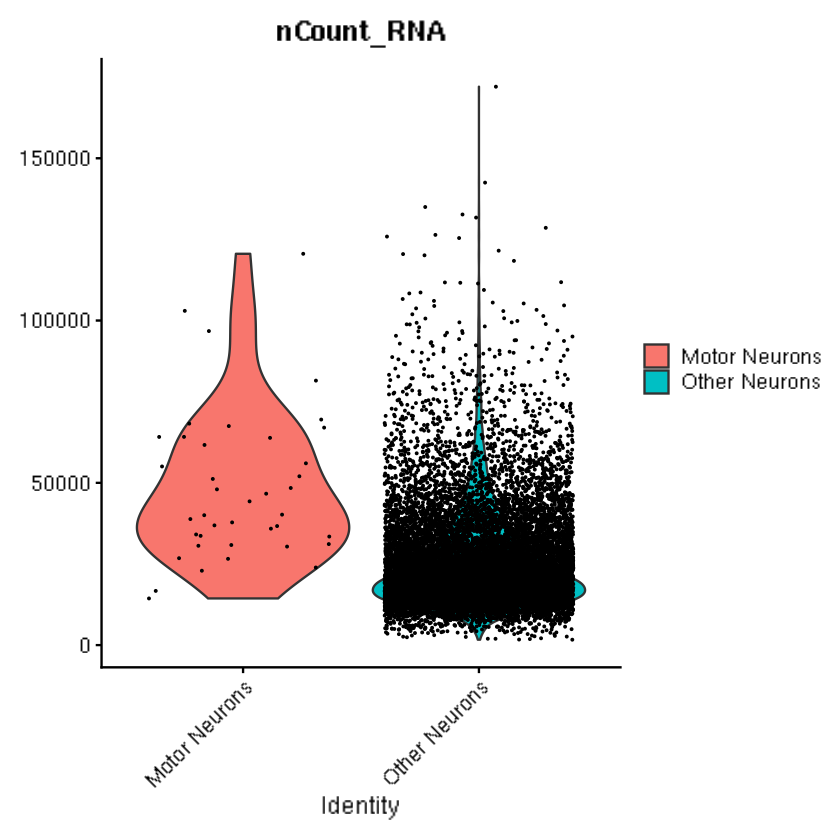

In [231]:
VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "nCount_RNA")

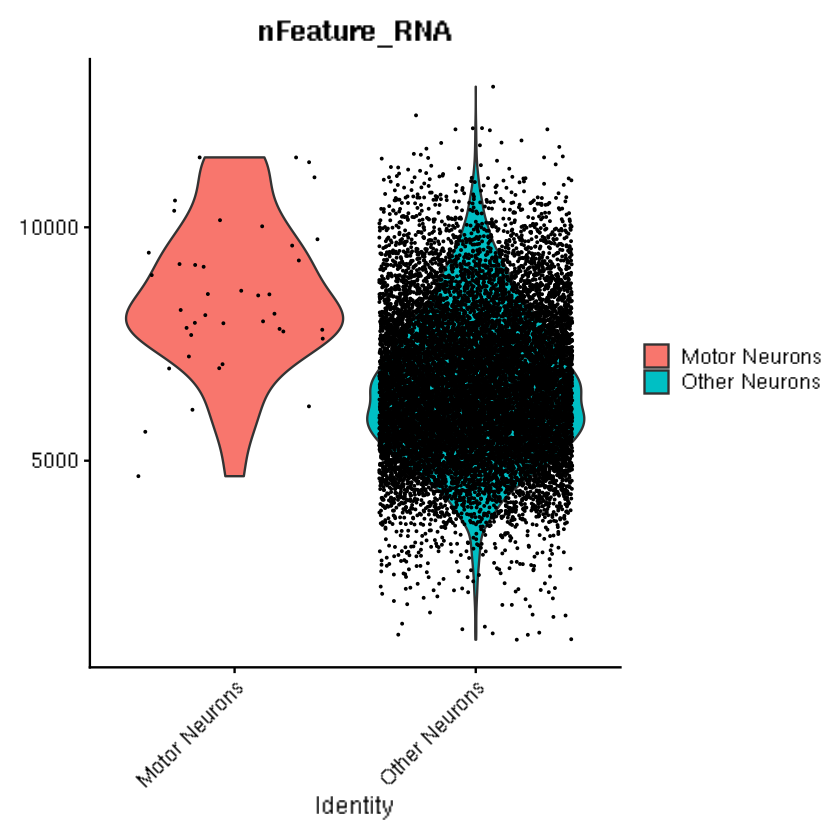

In [232]:
VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "nFeature_RNA")

In [233]:
median_nCount <- filter(gautier_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nCount_RNA)}

In [234]:
median_nCount

[1] 21790

In [235]:
filter(gautier_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nCount_RNA)}

[1] 42241

In [236]:
gautier_neurons$norm_nCount_RNA = gautier_neurons$nCount_RNA/median_nCount

In [237]:
median_nFeature <- filter(gautier_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$nFeature_RNA)}

In [238]:
median_nFeature

[1] 6495

In [239]:
filter(gautier_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$nFeature_RNA)}

[1] 8384

In [240]:
gautier_neurons$norm_nFeature_RNA = gautier_neurons$nFeature_RNA/median_nFeature

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



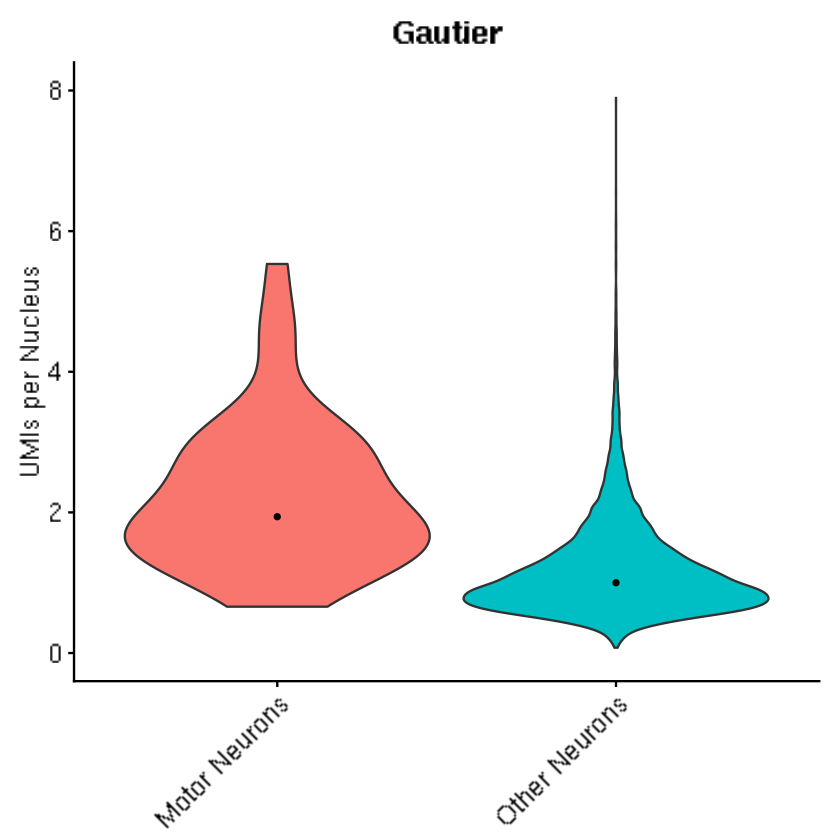

In [9]:
gautier_norm_nCount_RNA <- VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "norm_nCount_RNA", pt.size = 0) + 
  labs(title = "Gautier", y = "UMIs per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,8)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

gautier_norm_nCount_RNA

In [10]:
ggsave(gautier_norm_nCount_RNA, filename = paste(fig_dir, 'gautier_norm_nCount_RNA2.svg', sep='/'), device='svg', width = 3.4, height = 3.55, units = "in")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”


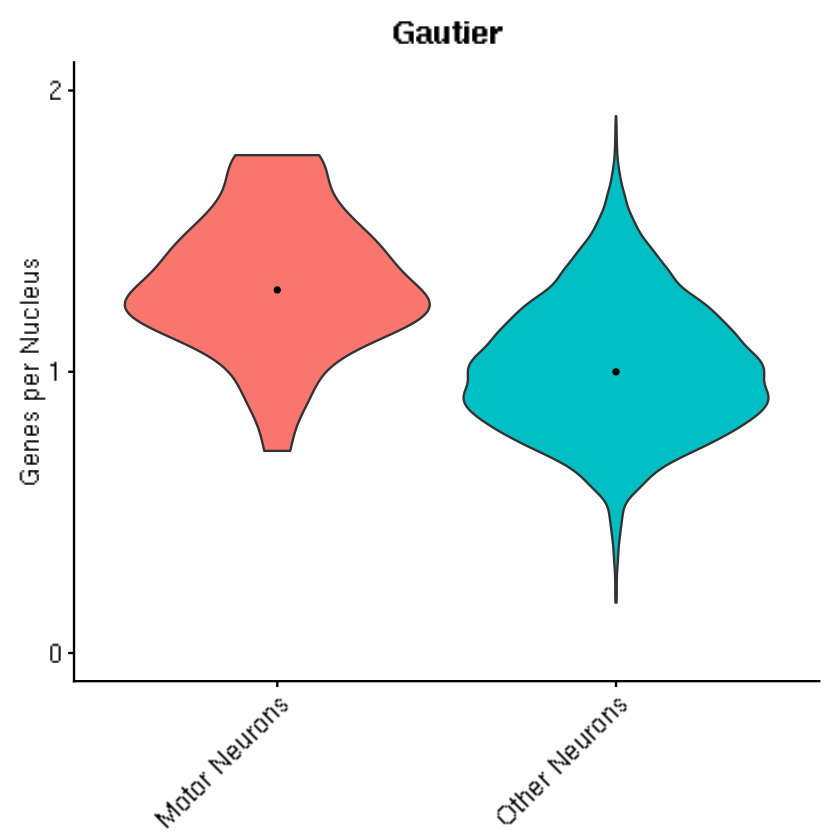

In [5]:
gautier_norm_nFeature_RNA <- VlnPlot(gautier_neurons, group.by = "motor_neuron", features = "norm_nFeature_RNA", pt.size = 0) + 
  labs(title = "Gautier", y = "Genes per Nucleus") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,2), breaks=c(0,1,2)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank())

gautier_norm_nFeature_RNA

In [6]:
ggsave(gautier_norm_nFeature_RNA, filename = paste(fig_dir, 'gautier_norm_nFeature_RNA2.svg', sep='/'), device='svg', width = 3.4, height = 3.55, units = "in")

Warning message:
“Removed 1 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_summary).”


## Motor neuron maker genes

In [245]:
Idents(gautier_neurons) <- gautier_neurons$motor_neuron

In [122]:
# Motor neuron vs. other neuron marker genes
mn.markers.downsamp <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", only.pos = TRUE, max.cells.per.ident = 40)
head(mn.markers.downsamp, n = 50)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CREB5,9.048712e-16,3.4662197,1.000,0.106,3.310743e-11
LCP1,1.215171e-15,1.1461940,1.000,0.139,4.446067e-11
PCA3,8.994433e-15,1.7744992,1.000,0.259,3.290883e-10
TANC1,1.201438e-14,1.7119742,1.000,0.265,4.395823e-10
NEAT1,1.368607e-14,3.0282762,1.000,0.557,5.007458e-10
PRUNE2,1.536310e-14,2.9124960,1.000,0.861,5.621051e-10
SLC5A7,1.655015e-14,2.8054180,1.000,0.082,6.055367e-10
SLIT3,2.013588e-14,2.3970508,1.000,0.407,7.367318e-10
SLIT2,6.042815e-14,2.0128669,1.000,0.659,2.210945e-09


In [123]:
# Motor neuron vs. other neuron marker genes
mn.markers <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", only.pos = TRUE)
head(mn.markers, n = 50)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC013265.1,0.000000e+00,1.3798517,0.625,0.008,0.000000e+00
AMTN,0.000000e+00,4.0959122,0.700,0.001,0.000000e+00
AC096773.1,0.000000e+00,0.3953270,0.425,0.004,0.000000e+00
MNX1,0.000000e+00,0.2621736,0.600,0.006,0.000000e+00
IL33,0.000000e+00,0.5118036,0.625,0.004,0.000000e+00
COL1A1,0.000000e+00,0.3001079,0.450,0.003,0.000000e+00
GRIN3B,0.000000e+00,0.4045918,0.625,0.006,0.000000e+00
PRPH,1.085950e-299,0.4678286,0.600,0.009,3.973272e-295
PALMD,1.187001e-271,0.9149330,0.875,0.022,4.343001e-267


## Volcano plot - motor neurons vs. other neurons

In [44]:
volcano.data <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", max.cells.per.ident = 500,logfc.threshold=0, min.pct=0)
#volcano.data$FDR = p.adjust(volcano.data$p_val, method='fdr')

In [46]:
volcano.data$gene <- rownames(volcano.data)
rownames(volcano.data) <- NULL

In [47]:
write.csv(volcano.data, file=paste(csv_dir, 'gautier_volcano_markers.csv', sep='/'))

In [13]:
volcano.markers <- read.csv(file=paste(csv_dir, 'gautier_volcano_markers.csv', sep='/'), header=T)

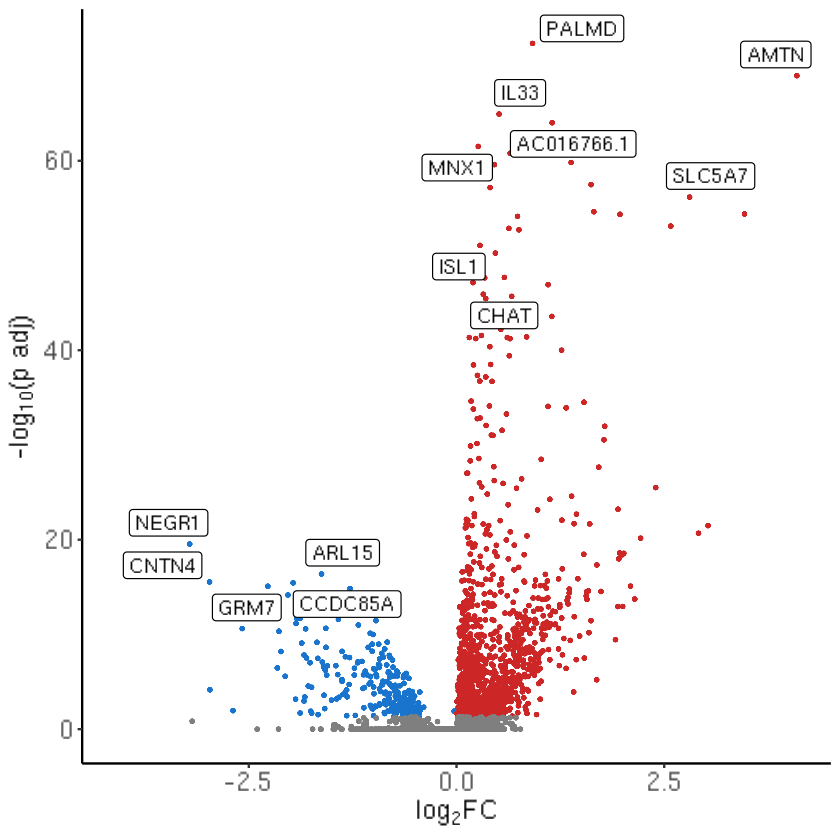

In [14]:
bonafide_mn_volcano_markers <- make_volcano_plot(as_tibble(volcano.markers), 5, labeled_genes = c('SLC5A7', 'ISL1', 'CHAT'), p_val_cutoff = 0.05)
bonafide_mn_volcano_markers <- rasterize(bonafide_mn_volcano_markers, layers="Point", dpi=500) + NoLegend()
bonafide_mn_volcano_markers

In [15]:
ggsave(bonafide_mn_volcano_markers, filename = paste(fig_dir, 'bonafide_mn_volcano_markers.svg', sep='/'), device='svg', width = 6.4, height = 4.848, units = "in")

## Subcluster motor neurons

In [246]:
gautier_mns <- subset(gautier_neurons, idents = "Motor Neurons")
gautier_mns

An object of class Seurat 
36588 features across 40 samples within 1 assay 
Active assay: RNA (36588 features, 33000 variable features)
 2 dimensional reductions calculated: pca, umap

In [247]:
gautier_mns <- FindVariableFeatures(gautier_mns, selection.method = "vst", nfeatures = 40)
all.genes <- rownames(gautier_mns)
gautier_mns <- ScaleData(gautier_mns, features = all.genes)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.301”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.1249e-14”
Centering and scaling data matrix



In [248]:
# PCA
gautier_mns <- RunPCA(gautier_mns, features = VariableFeatures(object = gautier_mns), approx = FALSE)

Warning message:
“Requested number is larger than the number of available items (40). Setting to 40.”
Warning message:
“Requested number is larger than the number of available items (40). Setting to 40.”
Warning message:
“Requested number is larger than the number of available items (40). Setting to 40.”
Warning message:
“Requested number is larger than the number of available items (40). Setting to 40.”
Warning message:
“Requested number is larger than the number of available items (40). Setting to 40.”
PC_ 1 
Positive:  NELL2, MAN1A1, DCHS2, NFIB, SGCZ, TPD52L1, RGS6, PDE1C, ADCY2, VIPR2 
	   ZNF804A, PLCB1, THSD7A, KCNMB4, SPOCK1, BRINP3, GABRG3, SGCD, SPARCL1, CACNA2D3 
Negative:  AC007319.1, MIR646HG, MATN1, RMST, PTPRT, AC079772.1, MGAT4C, CNTN4, TAFA2, TRPC5 
	   PDZRN4, PRKG1, PLD5, TAFA1, GRM5, UTS2, PTPRD, ROBO1, GNA14, PDK4 
PC_ 2 
Positive:  RMST, PRKG1, TAFA2, MGAT4C, PTPRT, CNTN4, TRPC5, GRM5, MIR646HG, GABRG3 
	   ROBO1, THSD7A, SPOCK1, PTPRD, AC007319.1, TAFA1, PLD5, SG

In [259]:
# Cluster
gautier_mns <- FindNeighbors(gautier_mns, dims = 1:2)
gautier_mns <- FindClusters(gautier_mns, resolution = 2, graph.name = "RNA_snn")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 40
Number of edges: 663

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.0116
Number of communities: 28
Elapsed time: 0 seconds


26 singletons identified. 2 final clusters.

Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


## Motor neuron UMAPs

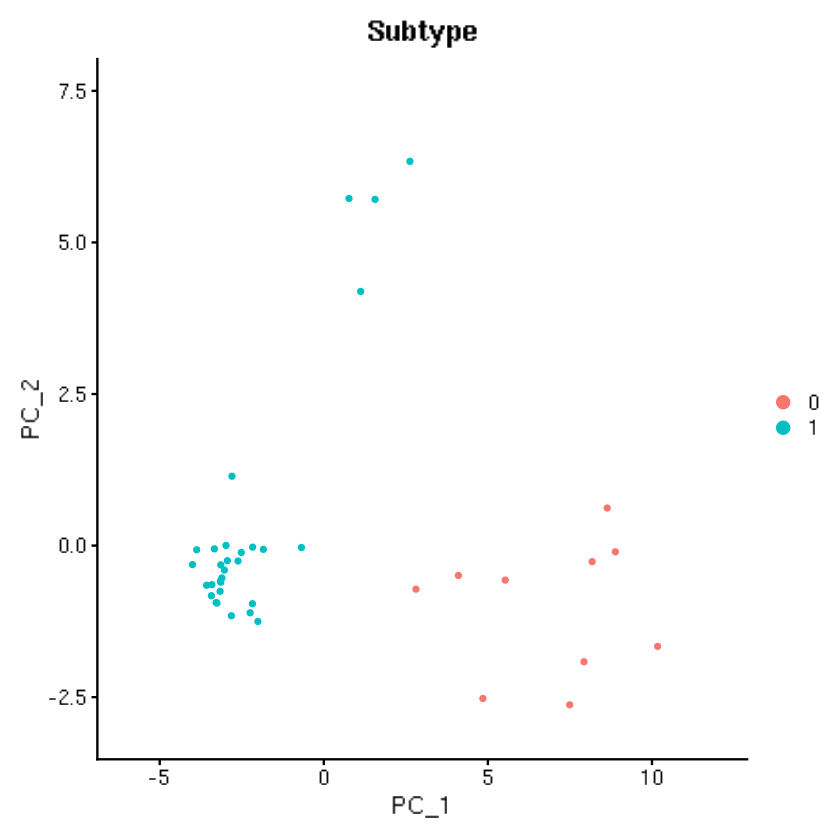

In [260]:
DimPlot(gautier_mns, reduction = "pca") + ggtitle("Subtype") + xlim(-6,12) + ylim(-3,7.5) + theme(plot.title = element_text(hjust = 0.5))

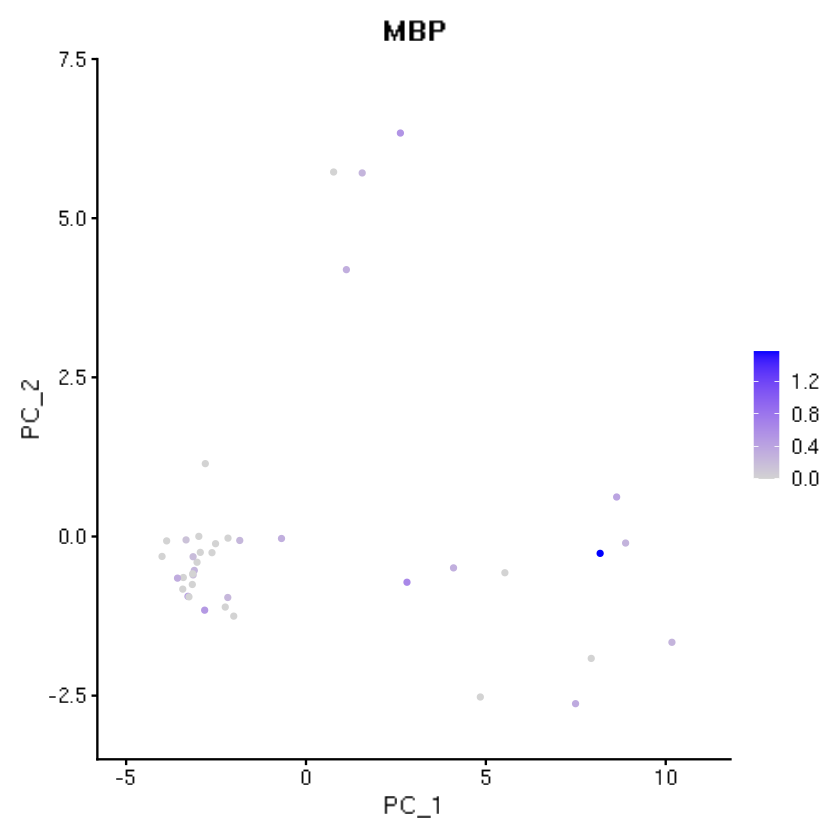

In [16]:
FeaturePlot(gautier_mns, reduction = "pca", features = c("MBP"))

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



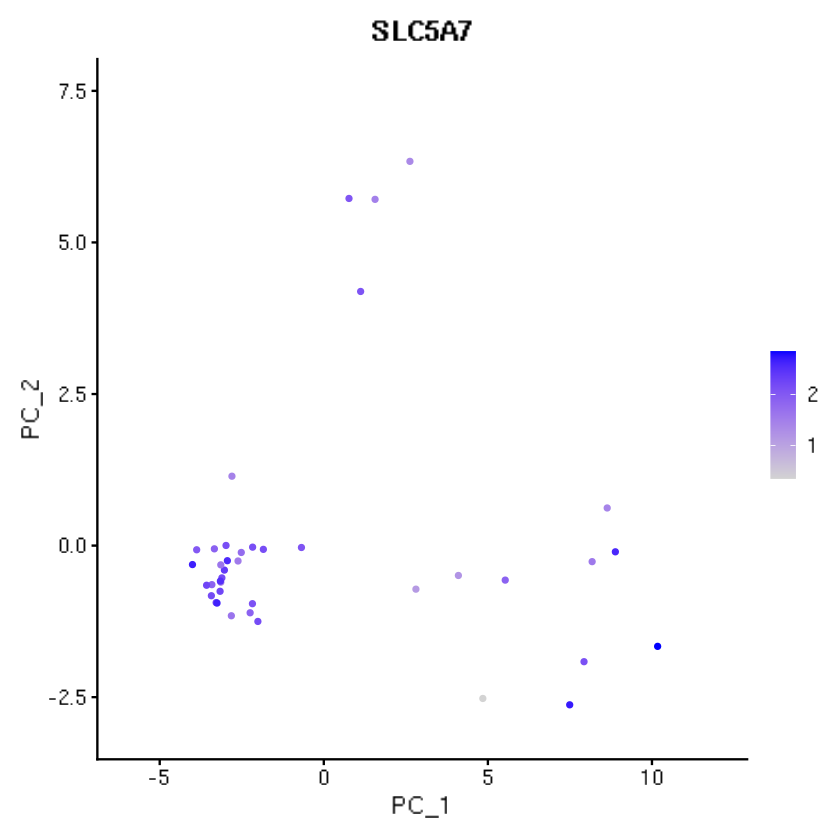

In [7]:
slc5a7_pca <- FeaturePlot(gautier_mns, reduction = "pca", features = c("SLC5A7")) + xlim(-6,12) + ylim(-3,7.5)
slc5a7_pca

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



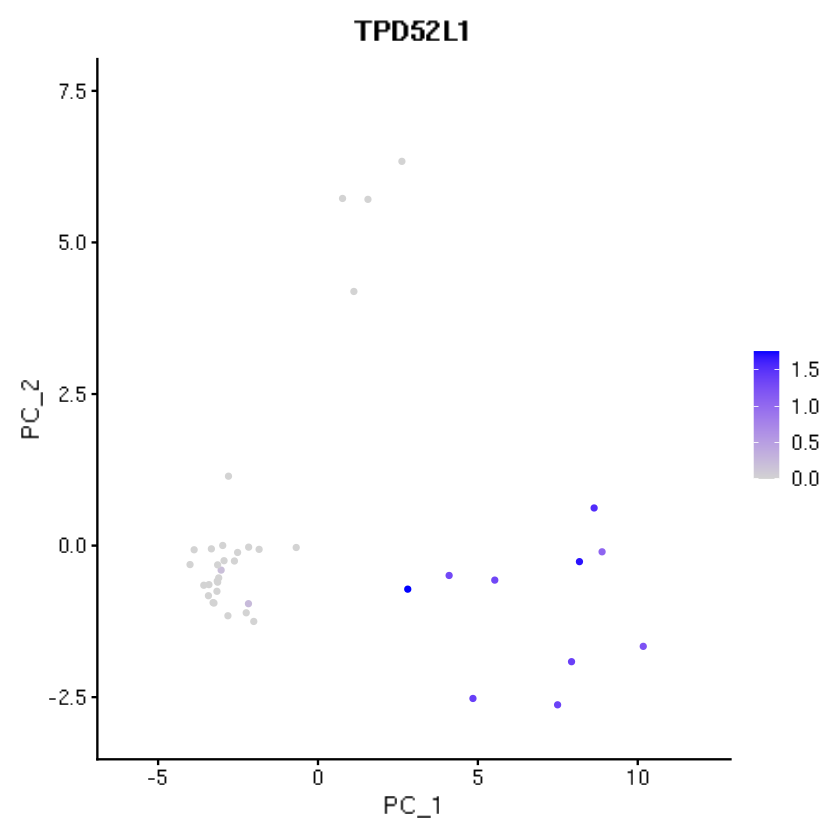

In [8]:
tpd52l1_pca <- FeaturePlot(gautier_mns, reduction = "pca", features = c("TPD52L1")) + xlim(-6,12) + ylim(-3,7.5)
tpd52l1_pca

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



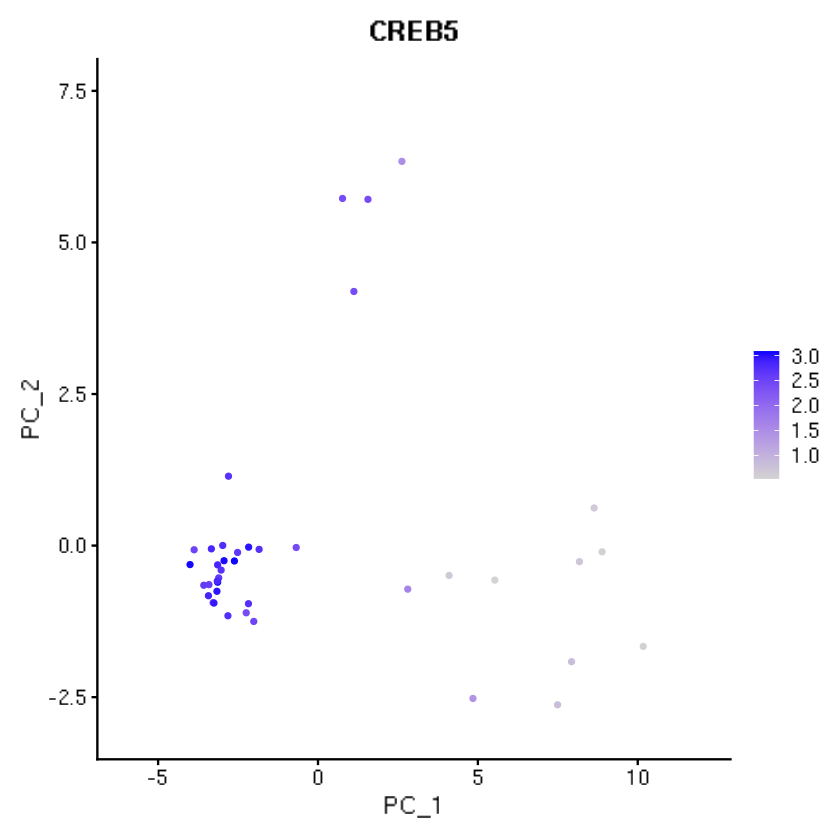

In [9]:
creb5_pca <- FeaturePlot(gautier_mns, reduction = "pca", features = c("CREB5")) + xlim(-6,12) + ylim(-3,7.5)
creb5_pca

In [261]:
gautier_mns$motor_neuron_subtype <- ifelse(gautier_mns$seurat_clusters == "0", yes = "Alpha", no = "Gamma")

In [262]:
Idents(gautier_mns) <- gautier_mns$motor_neuron_subtype

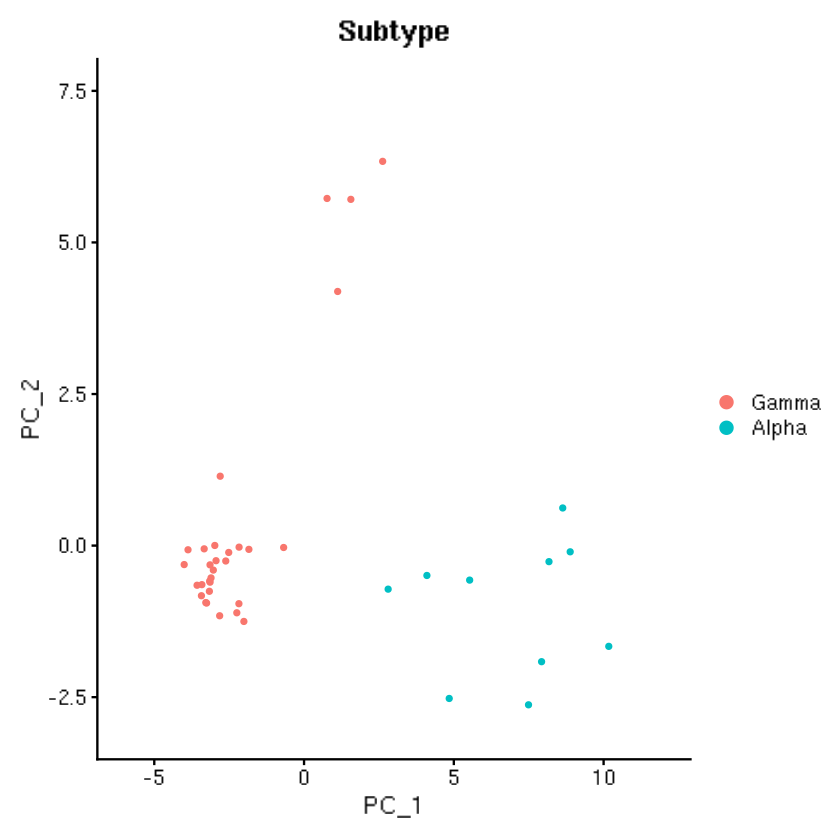

In [263]:
subtype_pca <- DimPlot(gautier_mns, reduction = "pca") + ggtitle("Subtype") + xlim(-6,12) + ylim(-3,7.5) + theme(plot.title = element_text(hjust = 0.5))
subtype_pca

In [27]:
ggsave(subtype_pca, filename = paste(fig_dir, 'subtype_pca.svg', sep='/'), device='svg', width = 3.56113, height = 2.75, units = "in")
#ggsave(slc5a7_pca, filename = paste(fig_dir, 'slc5a7_pca.svg', sep='/'), device='svg', width = 3.061, height = 2.75, units = "in")
#ggsave(tpd52l1_pca, filename = paste(fig_dir, 'tpd52l1_pca.svg', sep='/'), device='svg', width = 3.2, height = 2.75, units = "in")
#ggsave(creb5_pca, filename = paste(fig_dir, 'creb5_pca.svg', sep='/'), device='svg', width = 3.2, height = 2.75, units = "in")

In [62]:
alpha.markers <- FindMarkers(gautier_mns, ident.1 = "Alpha", only.pos = TRUE)
# head(alpha.markers, n = 50)

In [63]:
gamma.markers <- FindMarkers(gautier_mns, ident.1 = "Gamma", only.pos = TRUE)
# head(gamma.markers, n = 50)

## Volcano plot - alpha vs. gamma

In [40]:
alpha_gamma_volcano_markers <- FindMarkers(gautier_mns, ident.1 = "Alpha", ident.2 = "Gamma", logfc.threshold=0, min.pct=0)
alpha_gamma_volcano_markers$p_val_adj = p.adjust(alpha_gamma_volcano_markers$p_val, method='fdr')

In [41]:
alpha_gamma_volcano_markers$gene <- rownames(alpha_gamma_volcano_markers)
rownames(alpha_gamma_volcano_markers) <- NULL

In [53]:
alpha_gamma_volcano_plot <- make_volcano_plot(alpha_gamma_volcano_markers, 0, labeled_genes = c('PARD3B', 'CREB5', 'AMTN', 'TPD52L1', 'VIPR2', 'MT1X'), p_val_cutoff = 0.05) + ylab(label = expression("-log"[10]*"FDR"))
alpha_gamma_volcano_plot <- rasterize(alpha_gamma_volcano_plot, layers="Point", dpi=500) + NoLegend()

In [55]:
ggsave(alpha_gamma_volcano_plot, filename = paste(fig_dir, 'alpha_gamma_volcano_plot.svg', sep='/'), device='svg', width = 6.4, height = 4.848, units = "in")

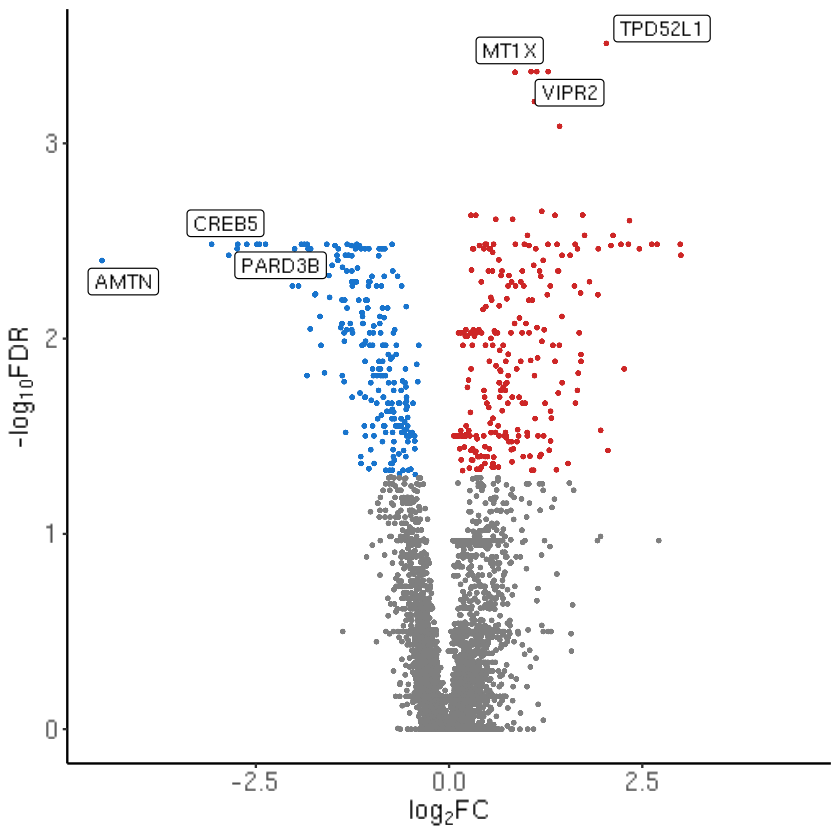

In [54]:
alpha_gamma_volcano_plot

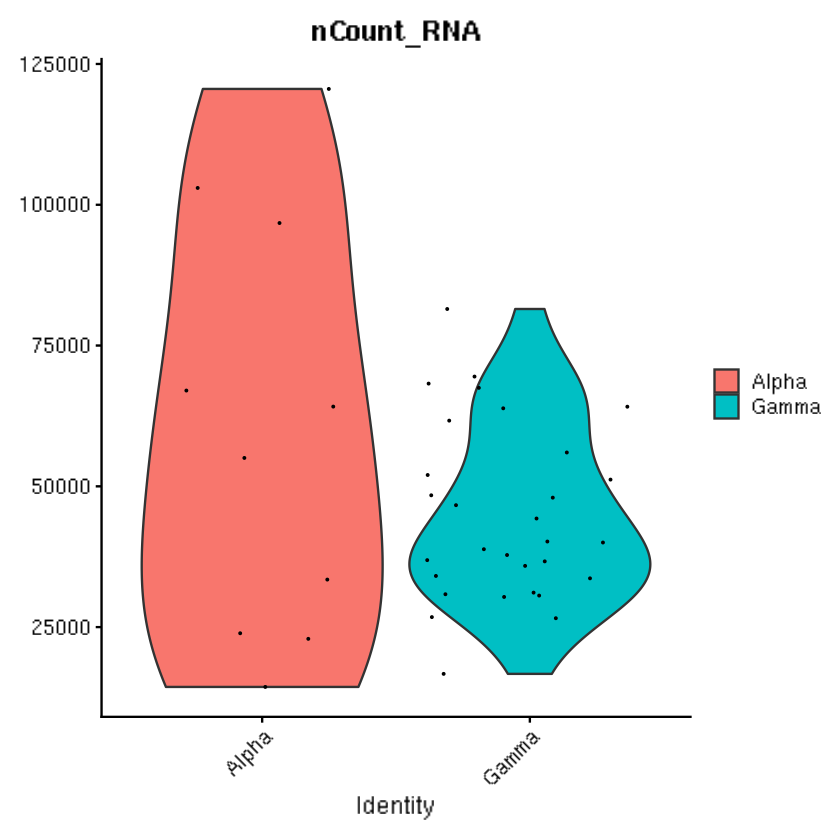

In [6]:
VlnPlot(gautier_mns, group.by = "motor_neuron_subtype", features = "nCount_RNA")

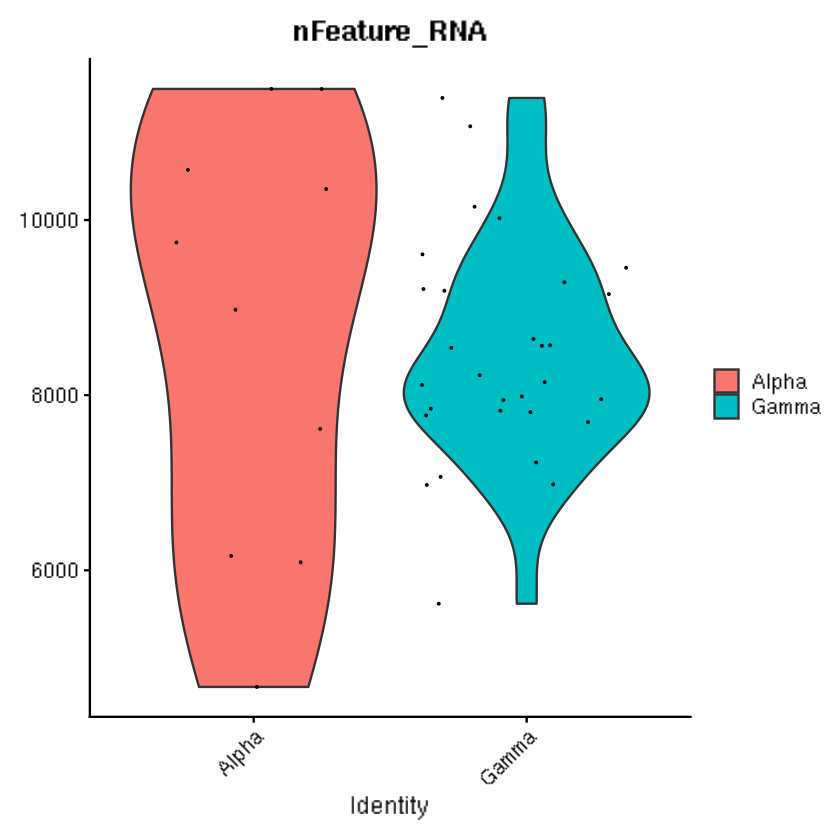

In [7]:
VlnPlot(gautier_mns, group.by = "motor_neuron_subtype", features = "nFeature_RNA")

## Save objects

In [267]:
saveRDS(gautier, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/gautier.rds')
saveRDS(gautier_neurons, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/gautier_neurons.rds')
saveRDS(gautier_prop_intronic, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/gautier_prop_intronic.rds')
saveRDS(gautier_mns, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/gautier_mns.rds')

## Load Objects

In [37]:
gautier <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier.rds')
gautier_prop_intronic <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic.rds')
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')
gautier_mns <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_mns.rds')